# INTRODUCTION

The goal of this notebook is to prepare a suitable classification model to predict the survival of the titanic disaster. 

The notebook is divided in the following sections:
1. **EXPLORATORY DATA ANALYSIS NUMERICAL COLUMNS**
2. **FEATURES ENGINEERING NUMERICAL COLUMNS**
3. **EXPLORATORY DATA ANALYSIS CATEGORICAL COLUMNS**
4. **AVOIDING DATA LEAKAGE**
5. **MISSING DATA IMPUTATION**
6. **MODEL SELECTION**
7. **PREPARING TEST DATA FOR THE PREDICTIONS** 

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns


In [39]:
df_train = pd.read_csv('train.csv')


In [40]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


# EXPLORATORY DATA ANALYSIS NUMERICAL COLUMNS

Let us start by dropping some columns that hardly enhance the predictivity of our model: PassengerId,Ticket,Name. After this let us analyse the numerical part of the database with the following strategy:

1. Print the correlation heatmap of all numerical variables including the target
2. Introduce a correlation threshold, that should be considered as a parameter of our model
3. Identify the column whose correlation with the target is below the threshold
4. Introduce a statistical test with null hypotesis no correlation with the target and remove the columns according to the test.


In [41]:
df_train.drop(['PassengerId', 'Name', 'Ticket'], axis=1,inplace=True)


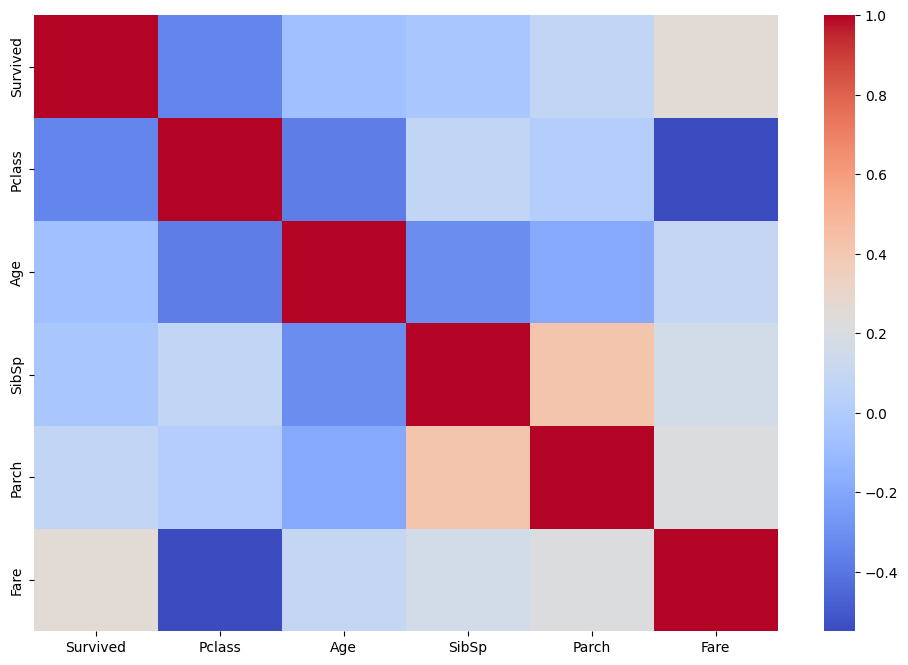

In [42]:
df_train_numerical = df_train.select_dtypes(['int64', 'float64'])
correlation_matrix = df_train_numerical.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt=".2f", cbar=True)

plt.show()

In [43]:
corr_threshold = 0.15
list_low_correlation = []

for column in df_train_numerical.columns:
    correlation_with_target = df_train_numerical[column].corr(df_train_numerical['Survived'])
    if np.abs(correlation_with_target) < corr_threshold:
        list_low_correlation.append(column)
        print(column)
        print(correlation_with_target)

Age
-0.07722109457217763
SibSp
-0.035322498885735666
Parch
0.08162940708348382


As mentioned before to analyse the columns with a correlation with the target below the threshold, we will perform a non-parametric statistical test, known as Spearman test. To do this we will introduce a threshold for the p-value. If the p-value resulting from the test is higher than the threshold (null hypothesis accepted), we are going to remove the column, if the p-value is below the threshold we are going to evaluate the absolute value of the correlation since if it is really small we might still decide to remove the column.

In [44]:
from scipy.stats import spearmanr


p_value_threshold = 0.05


for name in list_low_correlation:
     correlation_coefficient, p_value = spearmanr(df_train_numerical[name], df_train_numerical['Survived'])
     print(name)
     print(f'correlation:{correlation_coefficient}')
     print(f'p_value:{p_value}')
df_train.drop('SibSp', axis=1, inplace=True)

Age
correlation:nan
p_value:nan
SibSp
correlation:0.08887948468090501
p_value:0.007941431285733533
Parch
correlation:0.13826563286545587
p_value:3.453591460380432e-05


We decided to remove SibSp since even though the p-value is smaller than the threshold the absolut value of the correlation is really small, however we decided to keep the column 'Parch' since the p-value is extremely small and the correlation is above 0.1.

# FEATURE ENGINEERING NUMERICAL COLUMNS

The Spearman test didn't provide any informations about the column 'Age' which seems, from the heatmap extremely weakly correlated with the target, however we might ask what will happen if instead of considering all ages, we consider group of ages. The reason behind this is about the emergency procedure to prioritized the evacuation of women and children.

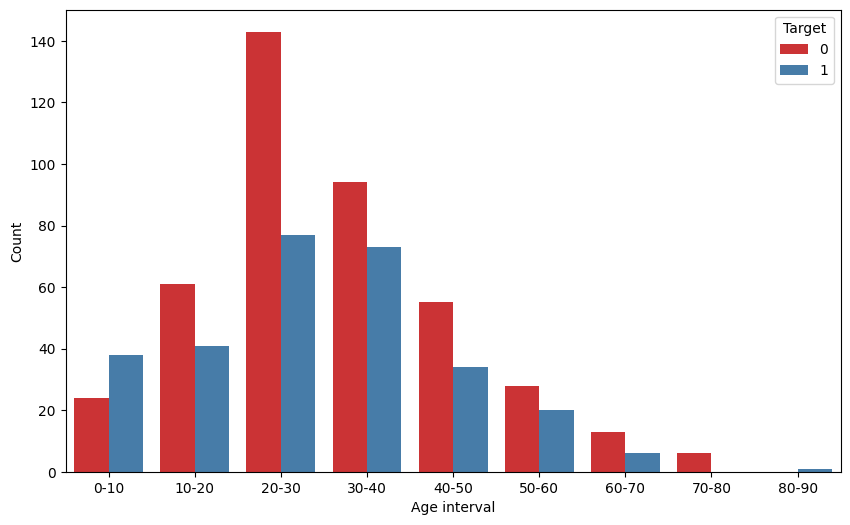

In [45]:
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90]
df_train['AgeGroup'] = pd.cut(df_train['Age'],bins=bins, right=False, labels=[f'{i}-{i+10}' for i in range(0, 90, 10)])


plt.figure(figsize=(10, 6))
ax = sns.countplot(x='AgeGroup', hue=df_train['Survived'], data=df_train, palette='Set1')


plt.xlabel('Age interval')
plt.ylabel('Count')
plt.legend(title='Target', labels = ['0', '1'])


In [46]:
df_train.info()
print(df_train['AgeGroup'])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   Survived  891 non-null    int64   
 1   Pclass    891 non-null    int64   
 2   Sex       891 non-null    object  
 3   Age       714 non-null    float64 
 4   Parch     891 non-null    int64   
 5   Fare      891 non-null    float64 
 6   Cabin     204 non-null    object  
 7   Embarked  889 non-null    object  
 8   AgeGroup  714 non-null    category
dtypes: category(1), float64(2), int64(3), object(3)
memory usage: 57.0+ KB
0      20-30
1      30-40
2      20-30
3      30-40
4      30-40
       ...  
886    20-30
887    10-20
888      NaN
889    20-30
890    30-40
Name: AgeGroup, Length: 891, dtype: category
Categories (9, object): ['0-10' < '10-20' < '20-30' < '30-40' ... '50-60' < '60-70' < '70-80' < '80-90']


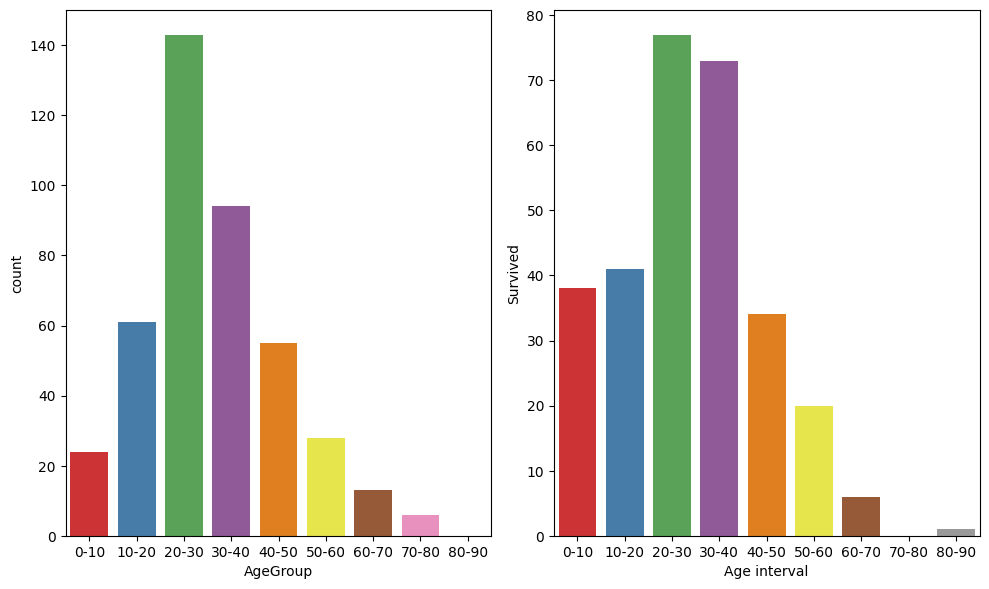

In [47]:
fig,axs=plt.subplots(1,2,figsize=(10, 6))
sns.countplot(x='AgeGroup', data=df_train[df_train['Survived'] == 0], palette='Set1', ax=axs[0])


plt.xlabel('Age interval')
plt.ylabel('Non-survived')
sns.countplot(x='AgeGroup', data=df_train[df_train['Survived'] == 1], palette='Set1', ax=axs[1])


plt.xlabel('Age interval')
plt.ylabel('Survived')


plt.tight_layout()
plt.show()



At this point, having the two distributions of survived people per group of age and non-survived people for group of age, we may perform a chi squared analysis to see if the differences between the two distribution are statistically significant.

In [48]:
from scipy.stats import chi2_contingency
contingency_table = pd.crosstab(df_train['Survived'], df_train['AgeGroup'])


chi2_stat, p_value, _, _ = chi2_contingency(contingency_table)

print(f"Statistica del chi-quadro: {chi2_stat}")
print(f"P-value: {p_value}")


if p_value < 0.05:
    print("Association between age group and surviving chance.")
else:
    print("Not enough indication against the independency.")

df_train.drop('Age', axis=1, inplace=True)

Statistica del chi-quadro: 20.981462659860245
P-value: 0.007196835697848083
Association between age group and surviving chance.


# EXPLORATORY DATA ANALYSIS CATEGORICAL COLUMNS

In [49]:
df_train_categorical = df_train.select_dtypes('object')

In [50]:
df_train_categorical.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Sex       891 non-null    object
 1   Cabin     204 non-null    object
 2   Embarked  889 non-null    object
dtypes: object(3)
memory usage: 21.0+ KB


**CABIN**: we are going to remove this column for essentially two reasons

1. High value of missing data
2. We have already a variable Pclass which may contain the relevant information about the importance of the position of the cabin, since usually cabins of a specific class tend to be in the same part of a boat, if there are connections between the survived passenger and the cabin assigned, this will be captured in the Pclass feature.

In [51]:
df_train.drop('Cabin', axis=1, inplace=True)

**SEX**,**EMBARKED**: we have to analyse these two features starting from a countplot of both.

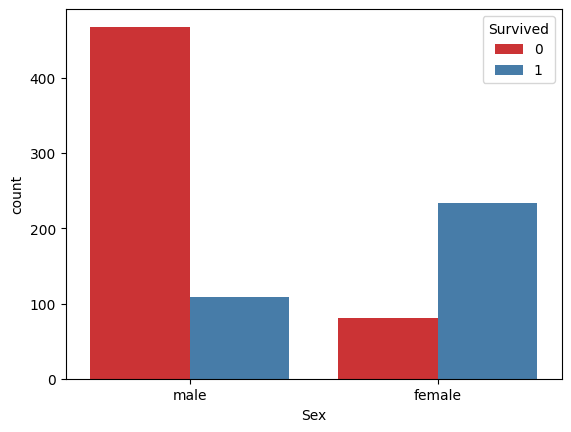

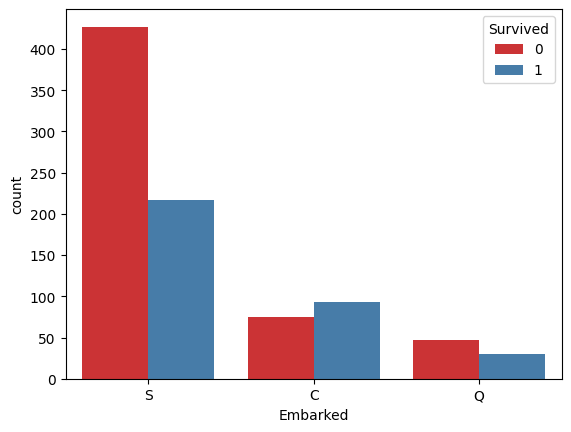

In [52]:
df_train_categorical = df_train.select_dtypes('object')

for column in df_train_categorical.columns:
  sns.countplot(x = column, hue='Survived', data=df_train, palette = 'Set1')
  plt.show()


It looks clear that women had a higher survival probability, as we mentioned before there was a priority to evacuate women and children. For the column Embarked it looks like different point lead to a different survival probability. Let us investigate more.

The idea here is to verify first if graphically people with a different Pclass had  differents survival chances, than we will check if the point of embarkation is related to people of different Pclass.

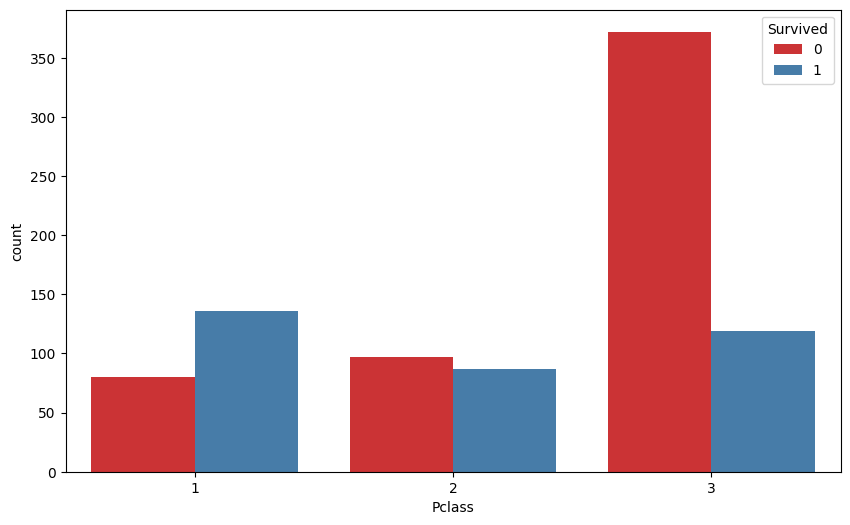

In [53]:

plt.figure(figsize=(10, 6))
ax = sns.countplot(x='Pclass', hue=df_train['Survived'], data=df_train, palette='Set1')

In [54]:
grouped = df_train.groupby('Embarked')['Pclass']

counts_per_group = grouped.value_counts().unstack(fill_value = 0)
print(counts_per_group)


Pclass      1    2    3
Embarked               
C          85   17   66
Q           2    3   72
S         127  164  353


As we can see it seems that the point of embarkation where we have a better ratio of surived people has a the biggest percentage of first class people, so even here we don't expect relevant changes in the model by keeping or not this column.

In this notebook I decided to keep the column since there are not many of them and it is not computational expensive at all.

In [55]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   Survived  891 non-null    int64   
 1   Pclass    891 non-null    int64   
 2   Sex       891 non-null    object  
 3   Parch     891 non-null    int64   
 4   Fare      891 non-null    float64 
 5   Embarked  889 non-null    object  
 6   AgeGroup  714 non-null    category
dtypes: category(1), float64(1), int64(3), object(2)
memory usage: 43.1+ KB


# AVOIDING DATA LEAKAGE

After selecting the features of our model, we are going before imputing the missing values, split the training set in the part to fit the model and a validation part. In this way we may avoid data leakage coming from the imputation of the missing values from the whole training dataset.

In [56]:
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(df_train, test_size=0.2, random_state=42)

df_train = X_train
df_validation = X_test

In [57]:
df_train.info()
df_validation.info()

<class 'pandas.core.frame.DataFrame'>
Index: 712 entries, 331 to 102
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   Survived  712 non-null    int64   
 1   Pclass    712 non-null    int64   
 2   Sex       712 non-null    object  
 3   Parch     712 non-null    int64   
 4   Fare      712 non-null    float64 
 5   Embarked  710 non-null    object  
 6   AgeGroup  572 non-null    category
dtypes: category(1), float64(1), int64(3), object(2)
memory usage: 40.0+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 179 entries, 709 to 10
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   Survived  179 non-null    int64   
 1   Pclass    179 non-null    int64   
 2   Sex       179 non-null    object  
 3   Parch     179 non-null    int64   
 4   Fare      179 non-null    float64 
 5   Embarked  179 non-null    object  
 6   AgeGroup  142 non-null    category
dty

# MISSING DATA IMPUTATION

We decided to impute missing data in the following way:

1. **Sex column**: assign a binary variable 
2. **AgeGroup** and **embarked**: ordinal encoding followed by a KNN imputation


In [58]:
df_train['Sex'] = df_train['Sex'].map({'male': 0, 'female': 1})
df_validation['Sex'] = df_validation['Sex'].map({'male': 0, 'female': 1})

df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 712 entries, 331 to 102
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   Survived  712 non-null    int64   
 1   Pclass    712 non-null    int64   
 2   Sex       712 non-null    int64   
 3   Parch     712 non-null    int64   
 4   Fare      712 non-null    float64 
 5   Embarked  710 non-null    object  
 6   AgeGroup  572 non-null    category
dtypes: category(1), float64(1), int64(4), object(1)
memory usage: 40.0+ KB


In [59]:
print(df_train['AgeGroup'])
df_train.head()

331    40-50
733    20-30
382    30-40
704    20-30
813     0-10
       ...  
106    20-30
270      NaN
860    40-50
435    10-20
102    20-30
Name: AgeGroup, Length: 712, dtype: category
Categories (9, object): ['0-10' < '10-20' < '20-30' < '30-40' ... '50-60' < '60-70' < '70-80' < '80-90']


,Survived,Pclass,Sex,Parch,Fare,Embarked,AgeGroup
331,0,1,0,0,28.5000,S,40-50
733,0,2,0,0,13.0000,S,20-30
382,0,3,0,0,7.9250,S,30-40
704,0,3,0,0,7.8542,S,20-30
813,0,3,1,2,31.2750,S,0-10


In [60]:
from sklearn.preprocessing import OrdinalEncoder

encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)
df_train['AgeGroup'] = encoder.fit_transform(df_train[['AgeGroup']])
df_validation['AgeGroup'] = encoder.fit_transform(df_validation[['AgeGroup']])
df_train['Embarked'] = encoder.fit_transform(df_train[['Embarked']])
df_validation['Embarked'] = encoder.fit_transform(df_validation[['Embarked']])


In [61]:
from sklearn.impute import KNNImputer

knn_imputer = KNNImputer(n_neighbors=5)
df_train = pd.DataFrame(knn_imputer.fit_transform(df_train), columns = df_train.columns)
df_validation = pd.DataFrame(knn_imputer.fit_transform(df_validation), columns = df_validation.columns)

In [62]:
df_validation.info()
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 179 entries, 0 to 178
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  179 non-null    float64
 1   Pclass    179 non-null    float64
 2   Sex       179 non-null    float64
 3   Parch     179 non-null    float64
 4   Fare      179 non-null    float64
 5   Embarked  179 non-null    float64
 6   AgeGroup  179 non-null    float64
dtypes: float64(7)
memory usage: 9.9 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 712 entries, 0 to 711
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  712 non-null    float64
 1   Pclass    712 non-null    float64
 2   Sex       712 non-null    float64
 3   Parch     712 non-null    float64
 4   Fare      712 non-null    float64
 5   Embarked  712 non-null    float64
 6   AgeGroup  712 non-null    float64
dtypes: float64(7)
memory usage: 39.1 KB


# MODEL SELECTION

The strategy here is to fit our database with different classification models and evaluate the performances with the accuracy percentage 

In [63]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier

X_train = df_train.drop('Survived', axis=1)
X_val = df_validation.drop('Survived', axis=1)

y_train = df_train['Survived']
y_val = df_validation["Survived"]

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

models = [
    GradientBoostingClassifier(),
    LogisticRegression(random_state=42),
    SVC(random_state=42),
    RandomForestClassifier(random_state=42),
    LinearDiscriminantAnalysis()
]

for model in models:
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    print(f"Accuracy {model.__class__.__name__}: {accuracy * 100:.2f}%")





Accuracy GradientBoostingClassifier: 82.12%
Accuracy LogisticRegression: 80.45%
Accuracy SVC: 81.01%
Accuracy RandomForestClassifier: 84.36%
Accuracy LinearDiscriminantAnalysis: 79.33%


In [64]:
model=SVC(random_state=42)

model.fit(X_train, y_train)

SVC(random_state=42)

We decided to select the SVC model since we analyse the database by changing many times the parameters and the selected features and the SVC approach was the one with a better stability.

# PREPARING TEST DATA FOR THE PREDICTIONS

The last task before computing our prediction is to prepare the test database in a suitable form to be used in our model for doing predictions. To do this we have to basically perform the same operations we did earlier to the train database

In [65]:
df_test = pd.read_csv('test.csv')
df_submission = df_test.copy()
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.1+ KB


In [66]:
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90]
df_test['AgeGroup'] = pd.cut(df_test['Age'], bins = bins, right=False, labels=[f'{i}-{i+10}' for i in range(0, 90, 10)])

In [67]:
for column in df_test.columns:
    if column not in df_train.columns:
        print(column)
        df_test.drop(column, axis=1, inplace=True)


PassengerId
Name
Age
SibSp
Ticket
Cabin


In [68]:
df_test['Sex'] = df_test['Sex'].map({'male': 0, 'female': 1})
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value = np.nan)
df_test['AgeGroup'] = encoder.fit_transform(df_test[['AgeGroup']])
df_test['Embarked'] = encoder.fit_transform(df_test[['Embarked']])


In [69]:
knn_imputer = KNNImputer(n_neighbors = 5)
df_test = pd.DataFrame(knn_imputer.fit_transform(df_test), columns=df_test.columns)

In [70]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    float64
 1   Sex       418 non-null    float64
 2   Parch     418 non-null    float64
 3   Fare      418 non-null    float64
 4   Embarked  418 non-null    float64
 5   AgeGroup  418 non-null    float64
dtypes: float64(6)
memory usage: 19.7 KB


In [71]:
df_submission.info()
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.1+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    float64
 1   Sex       418 non-null    float64
 2   Parch     418 non-nul

In [72]:
X_test = df_test


scaler = StandardScaler()
X_test = scaler.fit_transform(X_test)


y_test_pred = model.predict(X_test)
print(y_test_pred)


df_submission['Survived'] = y_test_pred
df_submission['Survived'] = df_submission['Survived'].astype(int)
print(df_submission["Survived"])

[0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0. 1. 0.
 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0.
 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 1. 0.
 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 0. 0. 0.
 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1.
 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0.
 1. 0. 1. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1.
 1. 1. 0. 0. 0. 0. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0.
 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0.

In [73]:
df_submission = df_submission[['PassengerId','Survived']]

In [74]:
df_submission.to_csv('submission.csv', index=False)